{'box_x1': 133, 'box_x2': 192, 'box_y1': 3104, 'box_y2': 3151}
Mean 17.676777 Std 1.818816 Min 13.714504 Max 25.08761


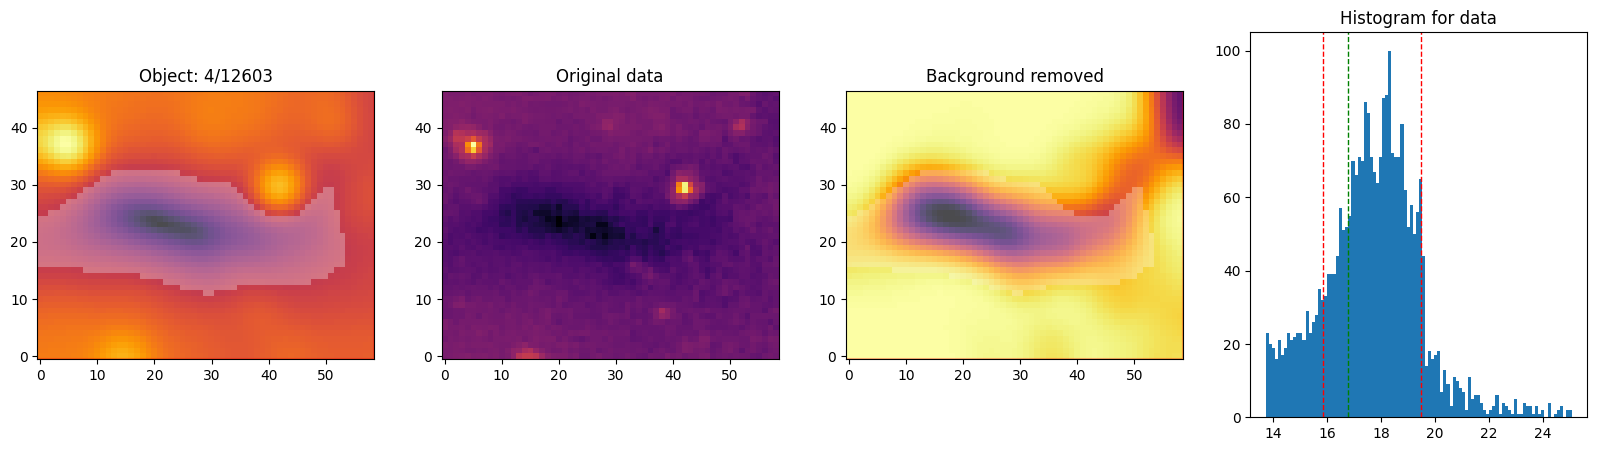

In [1]:
import random

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from matplotlib.colors import ListedColormap
from scipy import ndimage

from tempfile import mkdtemp
import os.path as path
from script.cloud_detection import *


def get_mask(row, data):
    blur_data = scipy.ndimage.gaussian_filter(data, sigma=3)

    threshold = np.percentile(blur_data, 30)
    # threshold = np.mean(blur_data) - 0.5*np.std(blur_data)
    mask = np.where(blur_data < threshold, True, False)

    return mask

FITS_PATH = "../data/fits/PROMISE-Q1-8micron-filled-v0_3.fits"
# FITS_PATH = '../data/fits/box47346.223_5974.1909_21.600045_21.600045_0.0.fits'
# FITS_PATH = '../cnn/fits_for_annotation/box(50316.355, 6033.3671, 234.3168, 178.3296, 0.0).fits'

# Open img using memmap to not load the whole image into memory
imageHDU = fits.open(FITS_PATH, memmap=True, mode="denywrite")

# read regfile
regions = read_regfile("../data/regions/cnn_negative_examples_merged.reg")

# plot random cloud
index = random.randint(0, len(regions) - 1)
index = 3
row = regions[index]
padding = 0
print(row)

data_temp = np.array(imageHDU[0].data[row["box_y1"]-padding:row["box_y2"]+padding, row["box_x1"]-padding:row["box_x2"]+padding], dtype=np.float32) # type: ignore

gauss = scipy.ndimage.gaussian_filter(remove_background_fourier(data_temp, 1), sigma=3)
blur_data = scipy.ndimage.gaussian_filter(data_temp, sigma=3)
threshold = np.mean(blur_data) - 0.5*np.std(blur_data)
print("Mean", np.mean(blur_data), "Std", np.std(blur_data), "Min", np.min(blur_data), "Max", np.max(blur_data))

mask = get_mask(row, data_temp)

# dilate mask
# mask = ndimage.binary_dilation(mask, iterations=2)

# blur mask
# mask = scipy.ndimage.gaussian_filter(mask, sigma=2)

### Plotting ###
plt.style.use({"image.origin": "lower", "image.interpolation": "nearest"})
extent = (-padding-0.5, row["box_x2"]+padding-row["box_x1"]-0.5, -padding-0.5, row["box_y2"]+padding-row["box_y1"]-0.5)
cmap1 = ListedColormap(['none', 'white']) # type: ignore
fig = plt.figure(figsize=(20, 5))

## Plot 1
ax = fig.add_subplot(1, 4, 1)
ax.imshow(blur_data, cmap='inferno', extent=extent, norm=ImageNormalize(stretch=SqrtStretch())) #type: ignore
ax.imshow(mask, cmap=cmap1, extent=extent, alpha=0.3)
ax.set_title("Object: " + str(index+1) + "/" + str(len(regions)))
ax.plot([-0.5, row["box_x2"]-row["box_x1"]-0.5, row["box_x2"]-row["box_x1"]-0.5, -0.5, -0.5], [-0.5, -0.5, row["box_y2"]-row["box_y1"]-0.5, row["box_y2"]-row["box_y1"]-0.5, -0.5], 'r-', alpha=0.3)

## Plot 2
ax = fig.add_subplot(1, 4, 2)
ax.imshow(data_temp, cmap='inferno', extent=extent, norm=ImageNormalize(stretch=SqrtStretch()))
ax.set_title("Original data")

## Plot 3
ax = fig.add_subplot(1, 4, 3)
ax.imshow(gauss, cmap='inferno', extent=extent)
ax.imshow(mask, cmap=cmap1, extent=extent, alpha=0.3)
ax.set_title("Background removed")
ax.plot([-0.5, row["box_x2"]-row["box_x1"]-0.5, row["box_x2"]-row["box_x1"]-0.5, -0.5, -0.5], [-0.5, -0.5, row["box_y2"]-row["box_y1"]-0.5, row["box_y2"]-row["box_y1"]-0.5, -0.5], 'r-', alpha=0.3);

ax = fig.add_subplot(1, 4, 4)
ax.hist(blur_data.flatten(), bins=100);
ax.set_title("Histogram for data")
# plot standard deviation
ax.axvline(np.mean(blur_data) + np.std(blur_data), color='r', linestyle='dashed', linewidth=1)
ax.axvline(np.mean(blur_data) - np.std(blur_data), color='r', linestyle='dashed', linewidth=1)
# plot threshold
ax.axvline(threshold, color='g', linestyle='dashed', linewidth=1)

In [2]:
import glob
import os

from tqdm import tqdm

print("Deleting all masks in data/masks")
files = glob.glob('../data/masks/*.npy')
for f in tqdm(files, "Deleting files", total=len(files)):
    os.remove(f)
print("Done!")

Deleting all masks in data/masks


Deleting files: 0it [00:00, ?it/s]

Done!


In [3]:
import secrets

maskname = path.join(mkdtemp(), 'mask.dat')

# loop through clouds and create catalog

output = []

mask = np.memmap(maskname, dtype='int32', mode='w+', shape=(12000,120000))

for row in tqdm(regions,"Generating masks", total=len(regions)):
    data_temp = np.array(imageHDU[0].data[row["box_y1"]-padding:row["box_y2"]+padding, row["box_x1"]-padding:row["box_x2"]+padding], dtype=np.float32) # type: ignore
    masked = get_mask(row, data_temp).astype(np.int32)
    mask[row["box_y1"]-padding:row["box_y2"]+padding, row["box_x1"]-padding:row["box_x2"]+padding] += masked

print("Biggest overlap", np.max(mask))
mask = mask.clip(0, 1).astype(bool)

# cut mask in to parts with overlap and process them individually
overlap = 4000
output = []
for X in tqdm(range(0, mask.shape[1], 12000), "Cutting mask in to parts"):
    if X+12000+overlap > mask.shape[1]:
        overlap = 0

    mask_temp = mask[:, X:X+12000+overlap]
    data_temp = np.array(imageHDU[0].data[:, X:X+12000+overlap], dtype=np.float32) # type: ignore
    mass_centers, objects, new_labels, dust_areas_new, remove_small_clouds, min_values, max_values, circularity = mask_manipulate(mask_temp, data_temp, overlap, 0, 0)
    output += format_for_ouput(mass_centers, objects, new_labels, dust_areas_new, min_values, max_values, circularity, X, 0, "../data/")

save_reg_and_csv(output, "cnn_negative_examples_merged_masks","../data/")
print("Done!")

Generating masks: 100%|██████████| 12603/12603 [00:13<00:00, 908.07it/s]


Biggest overlap 8


Cutting mask in to parts:   0%|          | 0/10 [00:00<?, ?it/s]d:\Programmering\Python\starseed\src\script\cloud_detection.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  circularity[i] = ((4 * np.pi * (np.sum(mask))) / np.power(np.sum(np.bitwise_xor(scipy.ndimage.binary_dilation(mask), mask)), 2))
Cutting mask in to parts: 100%|██████████| 10/10 [04:59<00:00, 29.94s/it]

Done!
